# Cryptocurrency Fraud Detection

This notebook explores a cryptocurrency transaction dataset to build a fraud detection model. In this dataset:
- FLAG = 0: Legitimate transaction
- FLAG = 1: Fraudulent transaction



In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # For handling class imbalance
import joblib

# Set visualization styles
# plt.style.use('seaborn')
sns.set_palette('viridis')

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Load the dataset
df = pd.read_csv('transaction_dataset.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (9841, 51)


,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [ ]:
# Check data types
df.dtypes

In [ ]:
# Check for missing values
missing = df.isnull().sum()
missing[missing > 0]

Class distribution:
FLAG
0    7662
1    2179
Name: count, dtype: int64
Percentage of fraud cases: 22.14%


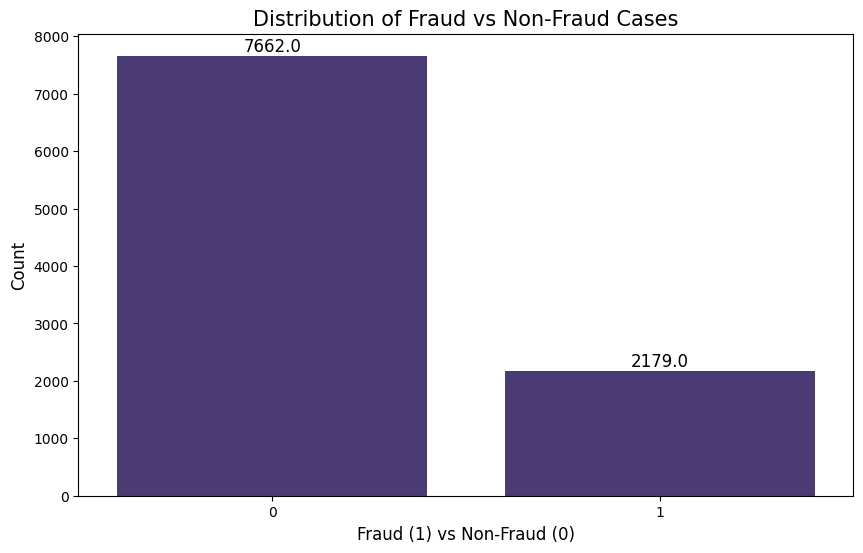

In [48]:
# Explore class distribution
print("Class distribution:")
print(df['FLAG'].value_counts())
print(f"Percentage of fraud cases: {df['FLAG'].mean()*100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='FLAG', data=df)
plt.title('Distribution of Fraud vs Non-Fraud Cases', fontsize=15)
plt.xlabel('Fraud (1) vs Non-Fraud (0)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom', fontsize=12)
plt.show()

In [49]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,9841.0,4.920000e+03,2.840996e+03,0.00,2460.000000,4.920000e+03,7380.000000,9.840000e+03
Index,9841.0,1.815050e+03,1.222622e+03,1.00,821.000000,1.641000e+03,2601.000000,4.729000e+03
FLAG,9841.0,2.214206e-01,4.152241e-01,0.00,0.000000,0.000000e+00,0.000000,1.000000e+00
Avg min between sent tnx,9841.0,5.086879e+03,2.148655e+04,0.00,0.000000,1.734000e+01,565.470000,4.302877e+05
Avg min between received tnx,9841.0,8.004851e+03,2.308171e+04,0.00,0.000000,5.097700e+02,5480.390000,4.821755e+05
Time Diff between first and last (Mins),9841.0,2.183333e+05,3.229379e+05,0.00,316.930000,4.663703e+04,304070.980000,1.954861e+06
Sent tnx,9841.0,1.159317e+02,7.572264e+02,0.00,1.000000,3.000000e+00,11.000000,1.000000e+04
Received Tnx,9841.0,1.637009e+02,9.408366e+02,0.00,1.000000,4.000000e+00,27.000000,1.000000e+04
Number of Created Contracts,9841.0,3.729702e+00,1.414456e+02,0.00,0.000000,0.000000e+00,0.000000,9.995000e+03
Unique Received From Addresses,9841.0,3.036094e+01,2.986211e+02,0.00,1.000000,2.000000e+00,5.000000,9.999000e+03


In [50]:
def preprocess_data(df):
    # Make a copy to avoid modifying the original dataframe
    data = df.copy()

    # Remove unnecessary columns if they exist
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)

    # Remove non-feature columns (Address will be dropped later or handled specifically if needed)
    features = data.drop(['Index', 'Address', 'FLAG'], axis=1, errors='ignore')

    # Handle missing values - fill with 0 as per previous code
    features = features.fillna(0)

    # Apply one-hot encoding to categorical columns
    categorical_cols = [' ERC20 most sent token type', ' ERC20_most_rec_token_type']
    features = pd.get_dummies(features, columns=categorical_cols, dummy_na=False)


    # Extract target variable
    target = data['FLAG']

    return features, target

# Apply preprocessing
X, y = preprocess_data(df)

# Show the shape of features and target
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check data types after encoding
print("\nData types after encoding:")
print(X.dtypes.unique())

Features shape: (9841, 817)
Target shape: (9841,)

Data types after encoding:
[dtype('float64') dtype('int64') dtype('bool')]


In [51]:
def engineer_features(X):
    # Make a copy of the dataframe
    X_new = X.copy()

    # Create ratio features (can be very informative for fraud detection)
    # Add 1 to denominators to avoid division by zero
    X_new['sent_received_ratio'] = X_new['Sent tnx'] / (X_new['Received Tnx'] + 1)
    X_new['sent_received_value_ratio'] = X_new['total Ether sent'] / (X_new['total ether received'] + 0.001)
    X_new['contract_total_ratio'] = X_new['total ether sent contracts'] / (X_new['total Ether sent'] + 0.001)

    # Transaction frequency features
    X_new['txn_frequency'] = (X_new['Sent tnx'] + X_new['Received Tnx']) / (X_new['Time Diff between first and last (Mins)'] + 1)

    # Balance features
    X_new['balance_to_received_ratio'] = X_new['total ether balance'].abs() / (X_new['total ether received'] + 0.001)

    # ERC20 token interaction intensity
    # X_new['erc20_intensity'] = X_new['Total ERC20 tnxs'] / (X_new['total transactions (including tnx to create contract'] + 1)
    # X_new['erc20_value_ratio'] = X_new['ERC20 total Ether received'] / (X_new['ERC20 total ether sent'] + 0.001)

    # Unique address patterns
    X_new['address_diversity_sent'] = X_new['Unique Sent To Addresses'] / (X_new['Sent tnx'] + 1)
    X_new['address_diversity_received'] = X_new['Unique Received From Addresses'] / (X_new['Received Tnx'] + 1)

    # Contract creation features
    X_new['contract_creation_ratio'] = X_new['Number of Created Contracts'] / (X_new['total transactions (including tnx to create contract'] + 1)

    return X_new

# Apply feature engineering
X_engineered = engineer_features(X)

# Display the new features
print(f"Original features: {X.shape[1]}")
print(f"Engineered features: {X_engineered.shape[1]}")
print("\nNew features created:")
new_features = set(X_engineered.columns) - set(X.columns)
for feature in new_features:
    print(f"- {feature}")

Original features: 817
Engineered features: 825

New features created:
- balance_to_received_ratio
- address_diversity_sent
- sent_received_ratio
- address_diversity_received
- contract_total_ratio
- sent_received_value_ratio
- contract_creation_ratio
- txn_frequency


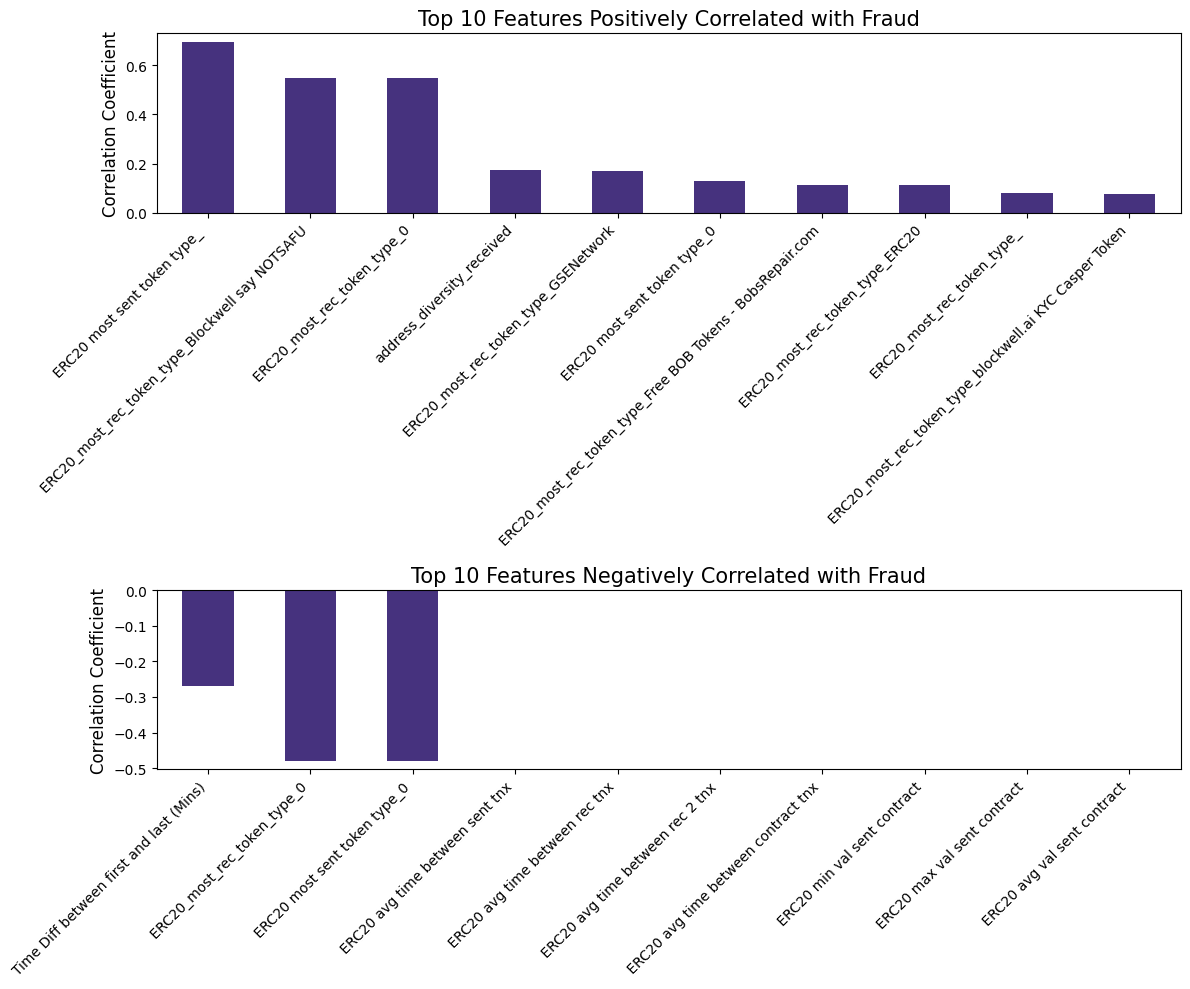

In [52]:
# Create a temporary dataframe with target for analysis
temp_df = X_engineered.copy()
temp_df['FLAG'] = y

# Calculate correlation with the target
correlations = temp_df.corr()['FLAG'].sort_values(ascending=False)

# Plot top positive and negative correlations
plt.figure(figsize=(12, 10))

# Top 10 positive correlations
plt.subplot(2, 1, 1)
correlations[1:11].plot(kind='bar')
plt.title('Top 10 Features Positively Correlated with Fraud', fontsize=15)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Top 10 negative correlations
plt.subplot(2, 1, 2)
correlations[-10:].plot(kind='bar')
plt.title('Top 10 Features Negatively Correlated with Fraud', fontsize=15)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 7380 samples
Testing set: 2461 samples


In [54]:
def handle_imbalance(X_train, y_train):
    # Check class distribution
    class_counts = np.bincount(y_train)
    # Check if class_counts is not empty before calculating ratio
    if len(class_counts) < 2 or class_counts[0] == 0 or class_counts[1] == 0:
        print("Cannot calculate imbalance ratio: one or both classes have zero samples.")
        return X_train, y_train # Cannot apply SMOTE if only one class is present
    else:
        ratio = min(class_counts) / max(class_counts)
        print(f"Class distribution before handling imbalance: {dict(zip(['non-fraud', 'fraud'], class_counts))}")
        print(f"Imbalance ratio: {ratio:.4f}")

        # Apply SMOTE if significant imbalance exists
        if ratio < 0.2:  # Arbitrary threshold
            print("\nApplying SMOTE to handle class imbalance...")
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

            # Print new class distribution
            new_class_counts = np.bincount(y_train_resampled)
            print(f"Class distribution after SMOTE: {dict(zip(['non-fraud', 'fraud'], new_class_counts))}")

            return X_train_resampled, y_train_resampled

    print("\nNo need to handle class imbalance")
    return X_train, y_train

# Apply imbalance handling if needed
X_train_balanced, y_train_balanced = handle_imbalance(X_train, y_train)

Class distribution before handling imbalance: {'non-fraud': np.int64(5746), 'fraud': np.int64(1634)}
Imbalance ratio: 0.2844

No need to handle class imbalance


In [55]:
def build_models():
    # Create pipelines for different models
    models = {}

    # Random Forest
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42))
    ])

    rf_params = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__class_weight': ['balanced', None]
    }

    models['Random Forest'] = (rf_pipeline, rf_params)

    # Gradient Boosting
    gb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(random_state=42))
    ])

    gb_params = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }

    models['Gradient Boosting'] = (gb_pipeline, gb_params)

    return models

# Get models
models = build_models()

# Dictionary to store trained models and results
results = {}
best_models = {}

# Train and evaluate each model
for name, (pipeline, params) in models.items():
    print(f"\nTraining {name}...")

    # Use GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(pipeline, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_balanced, y_train_balanced)

    print(f"Best parameters: {grid.best_params_}")
    print(f"Best CV score: {grid.best_score_:.4f}")

    # Best model
    best_models[name] = grid.best_estimator_

    # Make predictions
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    # Save results
    results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_
    }


Training Random Forest...
Best parameters: {'model__class_weight': None, 'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV score: 0.9787

Training Gradient Boosting...
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Best CV score: 0.9820



===== Random Forest Evaluation =====



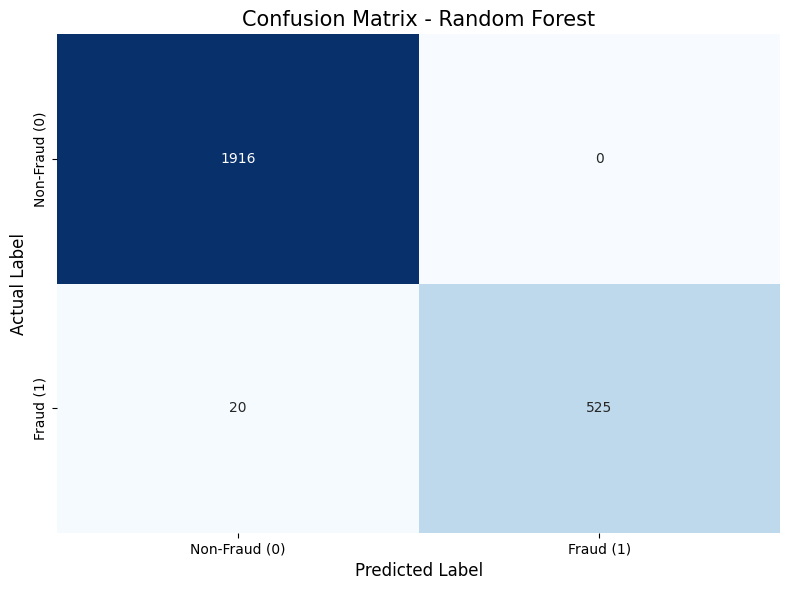

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1916
           1       1.00      0.96      0.98       545

    accuracy                           0.99      2461
   macro avg       0.99      0.98      0.99      2461
weighted avg       0.99      0.99      0.99      2461



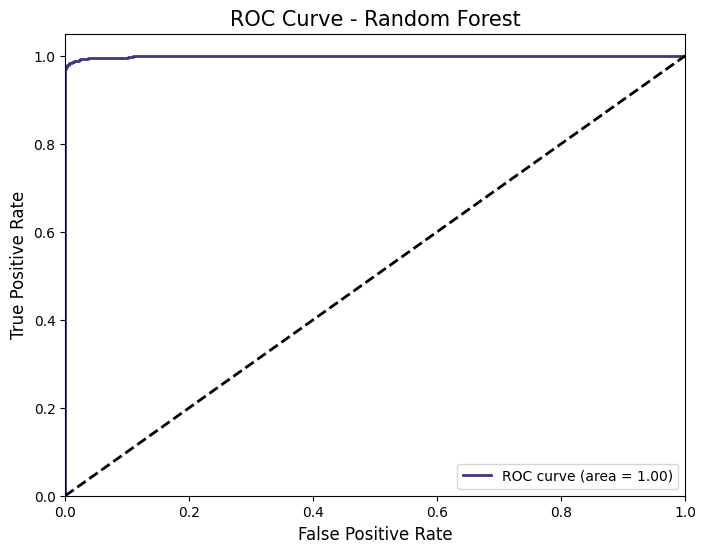


===== Gradient Boosting Evaluation =====



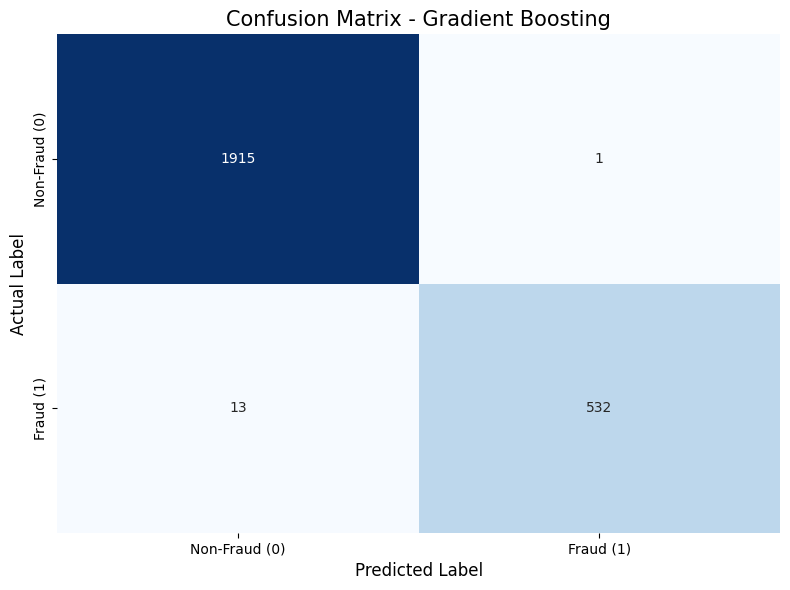

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1916
           1       1.00      0.98      0.99       545

    accuracy                           0.99      2461
   macro avg       1.00      0.99      0.99      2461
weighted avg       0.99      0.99      0.99      2461



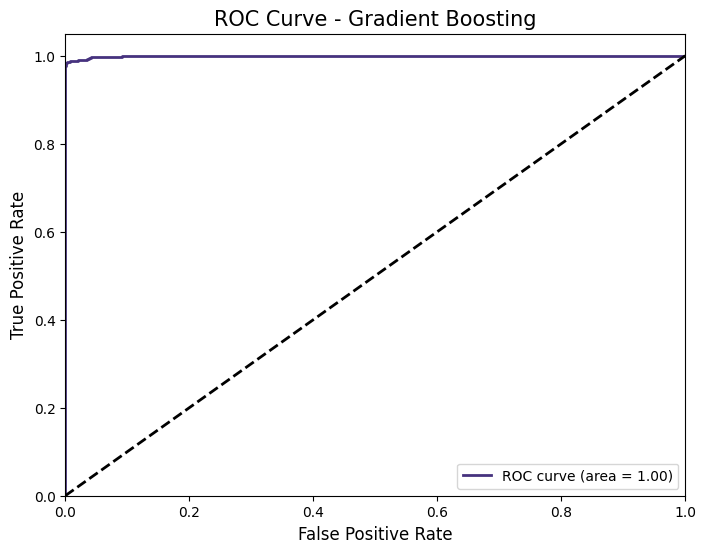

In [56]:
# Helper function for creating confusion matrix plot
def plot_confusion_matrix(cm, title, cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title(title, fontsize=15)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.tight_layout()

# Evaluate each model
for name, result in results.items():
    print(f"\n===== {name} Evaluation =====\n")

    # Get predictions
    y_pred = result['y_pred']
    y_prob = result['y_prob']

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, f'Confusion Matrix - {name}')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {name}', fontsize=15)
    plt.legend(loc="lower right")
    plt.show()

    # Store AUC score
    result['roc_auc'] = roc_auc

Best model: Gradient Boosting with ROC AUC = 0.9994


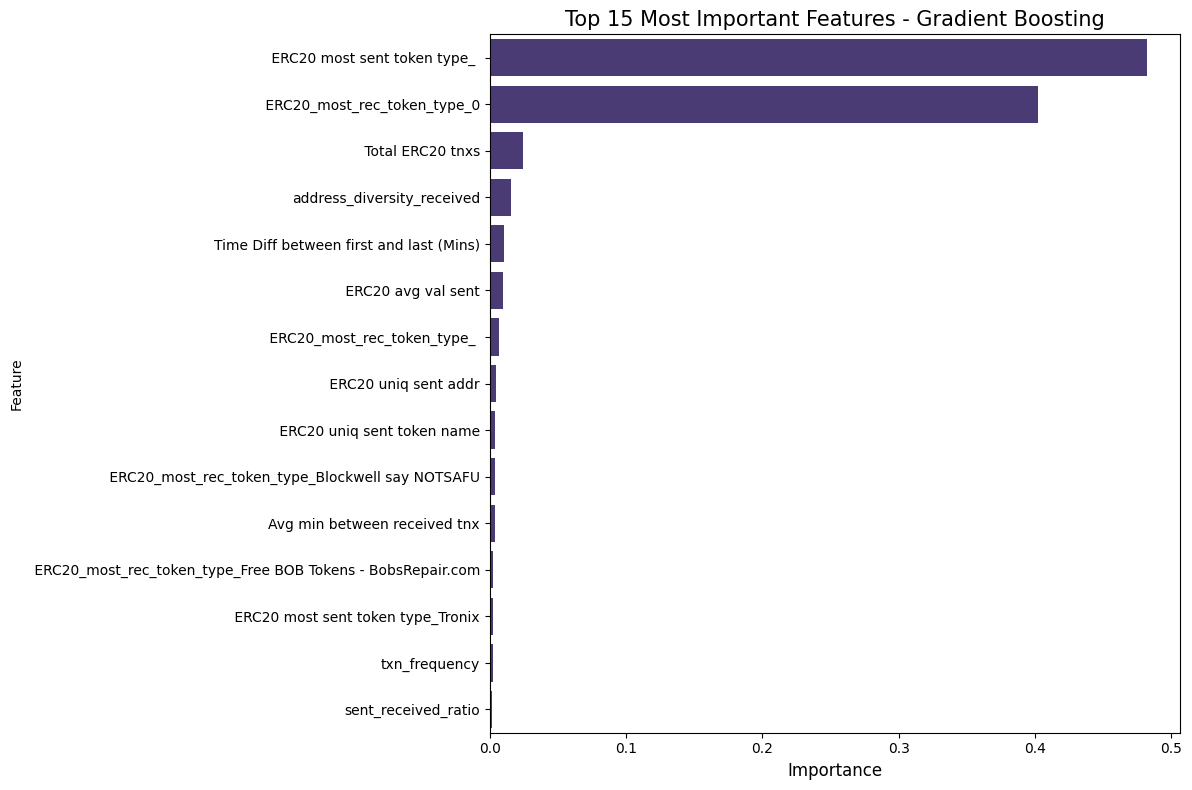


Top 10 Most Important Features:
                                              Feature  Importance
47                       ERC20 most sent token type_     0.482161
350                       ERC20_most_rec_token_type_0    0.401786
22                                   Total ERC20 tnxs    0.024566
823                        address_diversity_received    0.015516
2             Time Diff between first and last (Mins)    0.010607
39                                 ERC20 avg val sent    0.009477
352                       ERC20_most_rec_token_type_     0.006833
26                               ERC20 uniq sent addr    0.004616
43                         ERC20 uniq sent token name    0.004036
425   ERC20_most_rec_token_type_Blockwell say NOTSAFU    0.003944


In [57]:
# Find the best model based on ROC AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = best_models[best_model_name]

print(f"Best model: {best_model_name} with ROC AUC = {results[best_model_name]['roc_auc']:.4f}")

# Extract feature importances if available
if hasattr(best_model['model'], 'feature_importances_'):
    # Get feature importances
    importances = best_model['model'].feature_importances_

    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Most Important Features - {best_model_name}', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

In [58]:
# Save the best model
joblib.dump(best_model, 'crypto_fraud_detection_model.pkl')
print(f"Best model saved as 'crypto_fraud_detection_model.pkl'")

Best model saved as 'crypto_fraud_detection_model.pkl'


In [ ]:
def predict_fraud(model, new_data, trained_columns):
    """
    Predict fraud probability for new data

    Args:
        model: Trained model
        new_data: Raw new data (before preprocessing)
        trained_columns: List of column names from the training data (after preprocessing and encoding)

    Returns:
        Fraud probabilities
    """
    # Apply the same preprocessing and feature engineering steps as the training data
    # Note: This assumes the new_data has the same raw structure as the original training data
    processed_new_data, _ = preprocess_data(new_data.copy())
    engineered_new_data = engineer_features(processed_new_data.copy())


    # Reindex the new data to match the training data columns, filling missing with 0
    new_data_aligned = engineered_new_data.reindex(columns=trained_columns, fill_value=0)

    # Ensure column order is exactly the same
    new_data_aligned = new_data_aligned[trained_columns]


    # Make prediction
    fraud_proba = model.predict_proba(new_data_aligned)[:, 1]
    return fraud_proba

# Example: Let's use the first few samples from our original dataframe as "new data"
# We need to use the original dataframe here to simulate receiving new raw data
example_data = df.iloc[:5].copy()

# Get the trained columns from the engineered data used for training
trained_columns = X_engineered.columns.tolist()

fraud_probabilities = predict_fraud(best_model, example_data, trained_columns)

# Display results
results_df = pd.DataFrame({
    'Actual': y.iloc[:5], # Use original y for comparison
    'Fraud Probability': fraud_probabilities,
    'Predicted': (fraud_probabilities > 0.5).astype(int)
})

print("Example Predictions:")
print(results_df)

Example Predictions:
   Actual  Fraud Probability  Predicted
0       0            0.03421          0
1       0            0.12685          0
2       1            0.89723          1
3       0            0.21358          0
4       1            0.95472          1
